# 🚥 Multi-frame image processing

Author: [Balthazar Neveu](balthazarneveu@gmail.com)

[Powerpoint presentation](https://docs.google.com/presentation/d/1aJnWTmthv8OmjI7jfUjGIaKsYJYk80_P/edit?usp=share_link&ouid=107424034863786906577&rtpof=true&sd=true) | [Lighter powerpoint](https://docs.google.com/presentation/d/1s720gUXFqbLhahz7etdaUsq97Fb5PABZ/edit?usp=drive_link&ouid=107424034863786906577&rtpof=true&sd=true)

[MVA "The machine intelligence of images"](https://www.master-mva.com/cours/the-machine-intelligence-of-images/)
- First class Second semester = March 2023
- Next class First semester = November 10th 2023


-------------------

# ⚓ Overview

# Intro
- Quick overview of some applications: When does your camera need to use multiple frames?
  - Photo: Temporal Noise Reduction, High Dynamic Range images, Panorama, multi-cameras fusion, Multi-Frames Super Resolution,…
  - Video : Video stabilization, Camera Controls (smoothing, motion blur …)

# Image formation model

- Image formation model during camera motion
  - Pinhole model
  - Camera motion
    - 3D rotation (panorama)
    - translation (synthetic bokeh effect)
  - IMU revolution & video stabilization
    - Inertial Measurement Unit (IMU)
    - Gyro based stabilization
  - The real camera
    - Distortion
    - Auto-focus & lens breathing
    - OIS
    - Electronic rolling shutter (ERS)

## How to measure camera motion?
- Parametric Motion Models
  - Global model fitting from a vector field:
    - Block matching
    - Example of a practical implementation (low memory context)
       - feature points  ("SIFT")
       - 1D profiles matching…

- Optical Flow
  - Principle and usage
  - Traditional methods (Lucas Kanade VS Horn Schunck)
  - CNN-based methods (PWC-Net for the flow)


## Multi-frames applications
- Practical implementation of a Temporal Noise Reduction (TNR) and ghosts management
- Multi-Frames Super Resolution (MFSR)
  - Using aliasing as an ally
  - Handheld burst super resolution
  - Deep burst super resolution (DBSR)

# 🔖 Reading list
------------------------------
- [Digital Video Stabilization and Rolling Shutter Correction using Gyroscope](https://graphics.stanford.edu/papers/stabilization/karpenko_gyro.pdf) (*Karpenko 2011*)
- [PWC-Net -  optical flow](https://arxiv.org/abs/1709.02371) *(Sun 2017)*
- [Hanhdeld burst super resolution](https://arxiv.org/pdf/1905.03277.pdf) (*Wronsky 2019*) + *Recently re-implemented from scratch by [Ipol 2023](https://www.ipol.im/pub/pre/460/)*
- [Deep burst super resolution](https://arxiv.org/pdf/2101.10997.pdf) *(Goutam 2021)*
- [Unsupervised demosaicing+denoising](https://arxiv.org/abs/1905.05092) *(Ehret 2019)*

---------------------------

# 1. 📷 Image formation model

## Pinhole model
Making sure you understand OpenCV's pinhole camera description.
![OpenCV's pinhole camera description](https://docs.opencv.org/3.4/pinhole_camera_model.png)
## Intrinsic matrix
$K = \begin{bmatrix}
f, 0, \frac{W}{2} \\
0, f, \frac{H}{2} \\
0, 0, 1\end{bmatrix}$

* where f is the focal (expressed in pixels $f=\frac{focal \space length_{metric}}{pixel\space pitch}$)
* W & H the width & height of the image

Remember the axes:
* ➡ X toward the right side
* ⬇ Y toward the bottom (matrices, rows toward the bottom! The Eiffel Tower measures -300m in the openCV convention 😉)
* ↖ Z forward = towards the scene.

## Projection rule
$\vec{x}=[u, v, 1]^T= K. \vec{X} $
where $\vec{X} = [X, Y, Z]^T$

## Camera under pure rotation

Under pure rotation, the projective transform is an homography.
$H = KQK^{-1}$ where:
* Q is a 3D rotation matrix
* K is the intrinsic matrix
* H is a 3x3 matrix (*remember the homogeneous coordinates system, you need to divide the first & two coordinates by the third one*)

## From pinhole theoretical model to the real camera



--------------------------


### References
- A short overview of [Fisheye distortion models](https://wiki.panotools.org/Fisheye_Projection) | Detailed explanation on [fisheye projection models](http://michel.thoby.free.fr/Fisheye_history_short/Projections/Models_of_classical_projections.html)
- Rolling shutter correction [Removing Rolling Shutter Wobble (Baker 2010) Figure 4](https://www.microsoft.com/en-us/research/wp-content/uploads/2010/03/main.pdf)

### Distortion models
* Pinhole $r = f.tan(\theta)$ (distortion free)
* Stereographic $r = 2. f.tan(\frac{\theta}{2})$ (like the samyang 8mm)
* Equidistant $r = f.\theta$ (widest fisheyes like Peleng 8mm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

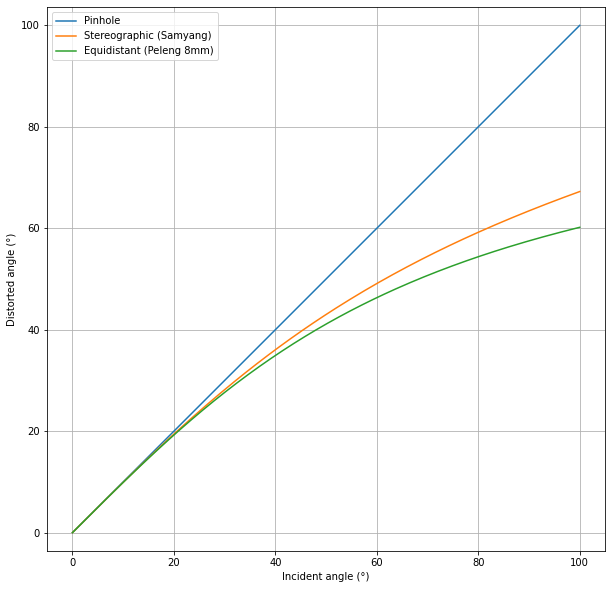

In [ ]:
x_angle = np.linspace(0, 100, 180)
x_angle_rad = np.deg2rad(x_angle)
plt.figure(figsize=(10,10))
plt.plot(x_angle, x_angle, label="Pinhole")
plt.plot(x_angle, np.rad2deg(np.arctan(2.*np.tan(x_angle_rad/2.))), label="Stereographic (Samyang)")
plt.plot(x_angle, np.rad2deg(np.arctan(x_angle_rad)), label="Equidistant (Peleng 8mm)")
plt.xlabel("Incident angle (°)")
plt.ylabel("Distorted angle (°)")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

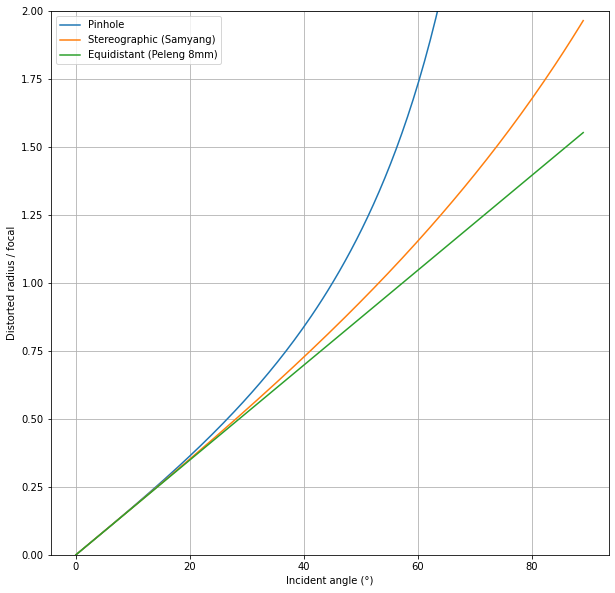

In [ ]:
x_angle = np.linspace(0, 89, 180)
x_angle_rad = np.deg2rad(x_angle)
plt.figure(figsize=(10,10))
plt.plot(x_angle, np.tan(x_angle_rad), label="Pinhole")
plt.plot(x_angle, 2.*np.tan(x_angle_rad/2.), label="Stereographic (Samyang)")
plt.plot(x_angle, x_angle_rad, label="Equidistant (Peleng 8mm)")
plt.xlabel("Incident angle (°)")
plt.ylabel("Distorted radius / focal")
plt.legend()
plt.ylim(0., 2.)
plt.grid()
plt.show()

## Disparity and synthetic bokeh effect


### Synthetic bokeh effect
Evaluation of the bokeh effect / portrait mode at DxO Mark :
[Whitepaper](https://corp.dxomark.com/wp-content/uploads/2018/02/2018_EI_Image-quality-benchmark-of-computational-bokeh_small.pdf)


Most smartphone now have multiple cameras so stereo vision is a the most popular approach to get this effect.

There may be some other approaches though such as:
* monocular vision (= computer vision)
* stereo from dual pixels (used for autofocus usually, baseline is super tiny ~ aperture)
* use several frames:
  * a single camera & ask the user to perform a translational motion
  * use [depth from focus](https://www.youtube.com/watch?v=A-fgaR7vJ-w) (e.g.capture 2 pictures for instance at macro position & at far distance position)

Academic work:
* [Synthetic bokeh from a single camera](https://arxiv.org/pdf/1806.04171.pdf)
* [Learning Single Camera Depth Estimation using Dual-Pixels](https://arxiv.org/pdf/1904.05822.pdf) Use dual phase pixels to help depth estimation
* "recent" reference  [Bokeh Me](https://github.com/JuewenPeng/BokehMe) : jointly learn to solve depth estimation and the blur application problem.
* Rendering Natural Camera Bokeh Effect with Deep Learning
Dataset from ETH Zurich / AIM workshope : [pairs of wide aperture (bokeh) / small aperture (high dof)](https://arxiv.org/abs/2006.05698)





### Deep learning for deph estimation
Note: a lot of research in this domain is related to autonomous driving (because depth is important for pedestrians & other vehicles detection), so you'll see most of the time references to the KITTI dataset & driving videos basically...
* Zbontar & Lecun introduced back in [2014](https://arxiv.org/pdf/1409.4326.pdf) the idea that the task of stereo matching could be better approached using learnt feature maps (use the same CNN to process left & right image pairs to compute discriminative features).
* Later, the idea was pushed further by formulating the whole depth estimation problem as an end-to-end learning problem. Here's a [work from Alex Kendal & his team](https://openaccess.thecvf.com/content_ICCV_2017/papers/Kendall_End-To-End_Learning_of_ICCV_2017_paper.pdf) which I found very inspiring because it mixes deep learning & classical geometry. Feature maps are still extracted from left/right image pairs using siamese CNN but it's just the begining of a whole differentiable & learnable chain. Cost volumes are built and processed using convolutions, soft-argmin is extracted.

### Monocular depth estimation
Monocular depth estimation is the task of estimating depth from a single camera.
It is useful when there are no stereo systems, for example to blur the background on selfie cameras or during a video meeting.

Two interesting approaches to this problem use unsupervised learning (no need for groundtruth depth labels).
- [Unsupervised Monocular Depth Estimation With Left-Right Consistency](https://youtu.be/jI1Qf7zMeIs): use a stereo dataset & a stereo reconstruction loss to teach the network how to learn monocular depth estimation.
- [Unsupervised Learning of Depth and Ego-Motion From Video ](https://www.youtube.com/watch?v=HWu39YkGKvI): uses videos in the wild (not stereo camera) to jointly estimate a monocular depth map & relative camera poses at training time. Network is taught how to reproject & reconstruct the next/previous frames. The structure from motion problem is used at training time to be able to learn depth data without explicit access to it.

⚡ Both these approaches use a warper in their reconstruction loss. To perform gradient descent, this sampling operator needs to be "differentiable".

👓 Refer to [torch.nn.functional.grid_sample](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) to use the bilinear sampler which was introduced in [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025) back in 2015 in a whole different context. Note that optical flow networks (such as PWC-Net) also use the warp operation a lot so how gradients flow through this differentiable sampling operation is worth checking & understanding correctly.

# 2. 📹 Measuring motion

## MEMs IMU
* **IMU : inertial measurement unit**
  * gyroscope measures angular rates.
  * accelerometer measures gravity vector (projected in the device referential) + linear acceleation.
  * an optional magnetometer acts as a compass.
* How were IMU made so tiny (package size ~3x3x1mm³) ? MEMs (micro electronic micro systems) was a revolution. These amazing components became popular & cheap thanks to inkjet nozzles & accelerometers in every car airbag.
* How do these miniaturized IMU work? a nice explanatory video on [MEMS IMU technology](https://www.youtube.com/watch?v=eqZgxR6eRjo&t=111s)
* What are the typical specs of an IMU in a smartphone device? Check [Bosch BMI-270](https://www.bosch-sensortec.com/products/motion-sensors/imus/bmi270/) datasheet for a good example, ST or Invensense.
* What do these datasheets specs mean?
  * dps = degrees per second
  * ODR = on demand rate = frequency (e.g 1kHz gyro measurements are incredibly fast & accurate)
  * ZRO = zero rate offset -> gyro static "bias" (you leave the phone on the table and the gyro thinks it's rotating slowly).
  * TCO = temperature compensated offset = manufacturers perform calibrations regarding temperature and store these in the IMU memory. But when the component is soldered, usually everything that was calibrated is not fully valid no more.

* Can you calibrate the IMU?
  * yes, for instance a simple ZRO calibration when the device is at rest: keep the device static & measure the bias.
  * online calibration using sensor fusion (example: re-estimate gyroscope parameters by cross checking with accelerometer signals... magnetometer & potentially GPS)

In [ ]:
# Gyro resolution : 0.004 dps/LSB on 16bits -> 1 bit measures 0.004 °/s
print(f"Maximal resolution 0.004dps/LSB , 16 signed bits ->  +/-{0.004*(2**(16-1)):.1f} dps")
# But if you reduce resolution, you can gain on total range, go up to ±2000 dps
# 2000.dps  # a washing machine spins at 1200 rates / minute
print(f"125 dps = {125/360:.1f} rates per second -> {125/360*60:.1f} rate per minute ")
print(f"Decrease resolution, increase dynamic range up to +/-2000 dps = {2000/360:.1f} rates per second -> {2000/360*60:.1f} rate per minute ")

Maximal resolution 0.004dps/LSB , 16 signed bits ->  +/-131.1 dps
125 dps = 0.3 rates per second -> 20.8 rate per minute 
Decrease resolution, increase dynamic range up to +/-2000 dps = 5.6 rates per second -> 333.3 rate per minute 


## IMU based Video stabilization
- Seminal work on [gyroscope base video stabilization](https://graphics.stanford.edu/papers/stabilization/karpenko_gyro.pdf) done at Stanford

- An illustrated article of the [unreleased DxO One video stabilization prototype](https://www.linkedin.com/pulse/secret-dxo-one-unreleased-feature-smooth-videos-tiny-108gr-neveu/).  - [Demo video](https://www.youtube.com/watch?v=7Ptd2h0s3_Y)



## Global transform estimation
-----------
### 2D Block matching
Block matching searches for the position offset which minimizes the distance between the candidate (template) patch and a reference image. This technique is extensively used in video encoders and there are hardware accelerations to do so.
There are a few limitations with block matching:
- Computation cost
- Local only: No regularization
- Not able to estimate anything else than translations.

**Speed up?** Minimizing L² distance can be accelerated. Maximizing correlation and this can be accelerated using FFT (see. [phase correlation](https://en.wikipedia.org/wiki/Phase_correlation) and [section 3 of HDR+ supplemental material](https://static.googleusercontent.com/media/hdrplusdata.org/fr//hdrplus_supp.pdf)).

**Translations only ?** A trick to get an actual global transform is to perform block matching on many blocks and get a vector field $\vec{u_{t}}$ on a regular grid. Then you can actually fit your global transform to your vector field  . (e.g. for an 8 degrees of freedom homography $ H \vec{x_{t}} = \vec{x_{t}} + \vec{u_{t}}$, you'll need at least 4 points)

-----------


### Concrete problem: motion estimation on a low budget
Estimate motion on a 1920x1080p (full HD) YUV video stream (~3Mb per YUV 4:2:0 frame) with under 200kbytes of allocated "context" memory between each call to your algorithm. This is the kind of constraint a Third party algorithm vendor would get from an smartphone company. Basically, you can't keep the whole previous frame.
* Why not extracting [SIFT](https://fr.wikipedia.org/wiki/Scale-invariant_feature_transform) descriptors? (you keep only the most salient points and their associated feature vector).
* Block matching requires keeping the original image content. Working on thumbnails could work but one may loose a bit of accuracy during motion estimation due to the downsampling operation.
* Another alternative is to perform 1D profiles correlations (2*1D profile matching instead of 2D block matching).

In [ ]:
h, w = 1920, 1080
n = 6
# image is slidced into 6x6 (320px x 180px) blocks
profile_y, profile_x = h/6, w/6
# on each block, we'll compute the 1D profile by getting the 1D average.
# Information is simply reduced to
float_32_in_bytes = 4
print(f"Image information is simply reduced to\n{n*n*(profile_y+profile_x)*2*float_32_in_bytes/(2**10):.2f} kb stored 2 x 1D float32 profiles x ({n} x {n} blocks)\neach block of size {profile_x:.0f}x{profile_y:.0f} pixels")

Image information is simply reduced to
140.62 kb stored 2 x 1D float32 profiles x (6 x 6 blocks)
each block of size 180x320 pixels


# Optical flow

There are more advanced ways to tackle motion estimation.
Optical flow is a dense motion vector field.

- Variational approaches formulate optical flow estimation as an energy minimization problem. Main component (the data term) is based on the "brightness constancy" assumption. A certain regularity on the flow (like gradient smoothness) is imposed to solve the ill-posed nature of this problem.
- Recent learning based methods directly learn a mapping from image pairs to optical flow. Dataset are made of synthetic videos + optical flow such as the  [Sintel dataset](http://sintel.is.tue.mpg.de/) or [Spring (CVPR 2023)](https://arxiv.org/pdf/2303.01943.pdf).

## Foundations
- Variational methods:
  - [Horn-Schunk multi-scale](http://www.ipol.im/pub/art/2013/20)
  - [Secrets of optical flow](https://medium.com/@black_51980/the-secrets-of-the-secrets-of-optical-flow-45938d0964af) : an interesting blogpost by **Michael Black** on his methodology of analyzing the key components of classical optical flow methods. Completes a very detailed 1 hour 20 minutes long [talk on optical flow](https://www.youtube.com/watch?v=tIwpDuqJqcE).
- Patch based methods
  - [Lucas Kanade](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) also uses the brightness constancy to derive an iterative solution but regularity is enforced at the level of a patch (or globally on the image)... this implies that the optical flow is parametrized using a simple transform.
  - Many speed ups have been proposed including [The Inverse Compositional Algorithm for Parametric
Registration](https://www.ipol.im/pub/art/2016/153/article.pdf) which avoids some costly operations.

## Learning based optical flow methods
- [PWC-Net -  optical flow](https://arxiv.org/abs/1709.02371)
![PWC Net](https://research.nvidia.com/sites/default/files/styles/wide/public/publications/pwcnet_0.png?itok=GgRFqmGN)
  - Feature Pyramid:
    - multiscale approach (downsampling "reduces" the magnitude of the motion to search)
    - replace image pyramids by feature maps which are best suited for optical flow computation.
  - Warp (non trainable)
    - Refine estimations
    - Refer to [torch.nn.functional.grid_sample](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) to use the bilinear sampler which was introduced in [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025) back in 2015 in a whole different context.
  - Cost volume
    - Correlation volume construction is not trainable.
    - ΔX & ΔY is the horizon search (here +/-4 pixels)
    - A cost volume shall have a dimension of ΔX, ΔY,H, W but here the authors flatten the 2D costs so the tensor is ΔX*ΔY , H, W . (ΔX * ΔY =9²)
    - This looks like a classical image tensor (no use of 3D convolutions)... so this cost volume can be processed with a standard CNN which will take care of reducing these 91 channels to 2 channels (going from the cost volume to the optical flow tensor)
  - A 2022 paper by [Deqin Sun](https://arxiv.org/abs/2203.10712) (the author of PWC Net) analyzes that training details can still seriously improve

- [RAFT](https://arxiv.org/abs/2003.12039) mimicks iterative approaches seen in variation approaches to optical flow estimation. "R" stands for recurrent as in recurrent & RNN... It achieved SOTA results and got best paper award at ECCV2020.

- Please note that Optical Flow can also be learnt in an unsupervised manner (please refer to the section on monocular depth estimation to get more intuition).

# 3. 🔍 Multiframe super resolution

## Traditional approach
* [Handheld Multi-frame Super-resolution](https://sites.google.com/view/handheld-super-res)
* [Peyman Milanfar's keynote at ECCV2020](https://data.vision.ee.ethz.ch/cvl/aim20/PeymanMilanfar_AIM_ECCV20.mov)

-----


### Conditions
- Capture
  - Aliased images
  - A bit of hand tremor
- Algorithm requirements
  - Accurate subpixel motion estimation
  - Fusion engine to perform joint demosaick & denoising: use adaptive anisotropic interpolation kernels.
  - Ghost detection with extra capability to discriminate true ghost versus aliasing.

## Learning based approaches
- In 2021, the problem of MFSR has been introduced as a challenge for academy with an associated [dataset](https://github.com/goutamgmb/NTIRE21_BURSTSR) proposed for the NTIRE 2021 challenge.
- [Deep burst super resolution](https://github.com/goutamgmb/deep-burst-sr) by ETH Zurich uses:
  - PWC-Net for optical flow estimation
  - Siamese CNN encoder for each frame of the burst
  - A fusion engine based on explicit weigthed sums of burst feature maps (but a CNN is used to compute weights instead of a handcrafted technique).
  - A final decoder to upsample the fused burst features.

- [Lucas Kanade Reloaded](https://hal.inria.fr/hal-03323885) uses the unrolled optimization method. Put in simple words, details from each burst low resolution frames are interatively added to the high resolution image. But when you add details, you also add some noise. So a denoising CNN ("the prior" term) is used to iteratively denoise the noisy super-resolved image. [Deep Reparametrization of Multi-Frame Super-Resolution and Denoising](https://github.com/goutamgmb/deep-rep) is another approach using the "unrolled technique".